In [ ]:
# ---[B] Mount Google Drive (If it's not already mounted, uncomment the following) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install rasterio
!pip install whitebox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 1.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import whitebox

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# =========================
# Standardize the output directory (automatically created)
# =========================
RESULT_DIR = "/content/drive/My Drive/Oyster_Flow/OFG_result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Set the WhiteboxTools working directory (all WBT output will be stored here)
wbt = whitebox.WhiteboxTools()
wbt.set_working_dir(RESULT_DIR)

# Enter the file path (unchanged)
flow_accum = "/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif"
flow_dir   = "/content/drive/My Drive/Oyster_Flow/FlowDir_Fill31.tif"

# Note: The following three "output" tif files will now be written to RESULT_DIR (only the path is changed, not the filename).
streams_rast   = os.path.join(RESULT_DIR, "HS_slope_streams.tif")
stream_link_r  = os.path.join(RESULT_DIR, "HS_slope_link.tif")
stream_order_r = os.path.join(RESULT_DIR, "HS_slope_order.tif")


threshold_list = list(range(52))

# Environment variable TIF file path (unchanged)
base_dir = "/content/drive/My Drive/Oyster_Flow/OFG_New/"
biogeo_tifs = [
    "NO30.tif", "NO31.tif", "NO32.tif",
    "chlorophyll0.tif", "chlorophyll1.tif", "chlorophyll2.tif",
    "salt0.tif", "salt1.tif", "salt2.tif",
    "temp0.tif", "temp1.tif", "temp2.tif",
    "u0.tif", "u1.tif", "u2.tif",
    "v0.tif", "v1.tif", "v2.tif",
    "w0.tif", "w1.tif", "w2.tif"
]

# Preload environment variable TIF data into memory
def preload_tifs(tif_list, base_directory):
    tif_arrays = {}
    logging.info("预加载环境变量 TIF 数据...")
    for f in tqdm(tif_list, desc="加载 TIF 文件"):
        tif_path = os.path.join(base_directory, f)
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1).astype(np.float32)
                if src.nodata is not None:
                    data = np.where(data == src.nodata, np.nan, data)
            tif_arrays[f] = data
        except Exception as e:
            logging.error(f"读取 {tif_path} 时出错: {e}")
    return tif_arrays

tif_arrays = preload_tifs(biogeo_tifs, base_dir)

# Extracting flow networks and constructing network graphs
def extract_network(threshold):
    try:
        # Call WhiteboxTools to perform flow network extraction and connectivity analysis (output points to RESULT_DIR)
        wbt.extract_streams(flow_accum, streams_rast, threshold)
        wbt.stream_link_class(d8_pntr=flow_dir, streams=streams_rast, output=stream_link_r)
        wbt.strahler_stream_order(d8_pntr=flow_dir, streams=streams_rast, output=stream_order_r)
    except Exception as e:
        logging.error(f"An error occurred while WhiteboxTools was processing threshold {threshold} : {e}")
        return None, None, None, None, None, None

    try:
        with rasterio.open(streams_rast) as src:
            streams_data = src.read(1).astype(np.float32)
            transform = src.transform
            streams_crs = src.crs

        with rasterio.open(flow_accum) as src:
            flow_acc_data = src.read(1).astype(np.float32)
        flow_acc_data[flow_acc_data < 0] = 0

        with rasterio.open(stream_order_r) as src:
            stream_order_data = src.read(1).astype(np.float32)

    except Exception as e:
        logging.error(f"Error reading raster data: {e}")
        return None, None, None, None, None, None

    # Constructing the network graph: Select only nodes with flow network cells (value > 0)
    graph = nx.Graph()
    rows, cols = np.where(streams_data > 0)
    for r, c in zip(rows, cols):
        graph.add_node(
            (r, c),
            flow_acc=flow_acc_data[r, c],
            stream_order=stream_order_data[r, c]
        )

    # Use 4-neighborhood edges
    for r, c in zip(rows, cols):
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < streams_data.shape[0] and 0 <= nc < streams_data.shape[1]:
                if streams_data[nr, nc] > 0:
                    graph.add_edge((r, c), (nr, nc))

    return graph, streams_data, transform, flow_acc_data, stream_order_data, streams_crs

# Collect samples and train models at a single threshold
def process_threshold(th, tif_arrays, biogeo_tifs):
    logging.info(f"Processing threshold = {th}")
    graph, streams_data, transform, flow_acc_data, stream_order_data, streams_crs = extract_network(th)
    if graph is None:
        return None

   # Calculate the whole map index
    num_components = nx.number_connected_components(graph)
    flow_efficiency = (
        np.mean([d["flow_acc"] for _, d in graph.nodes(data=True)])
        if graph.number_of_nodes() > 0 else 0
    )

   # Calculate node-level centrality
    if graph.number_of_nodes() > 0:
        deg_cent = nx.degree_centrality(graph)
        bet_cent = nx.betweenness_centrality(graph)
    else:
        deg_cent = {}
        bet_cent = {}

    samples = []
    for node in graph.nodes():
        r, c = node
        node_data = graph.nodes[node]

        y_dict = {
            "Connectivity": num_components,
            "Flow_Efficiency": flow_efficiency,
            "Degree_Centrality": deg_cent.get(node, 0),
            "Betweenness_Centrality": bet_cent.get(node, 0),
            "Stream_Order": node_data["stream_order"]
        }

        x_vals = []
        for f in biogeo_tifs:
            arr = tif_arrays.get(f, None)
            if arr is None:
                val = np.nan
            else:
                try:
                    val = arr[r, c]
                except IndexError:
                    val = np.nan
            x_vals.append(val)

        # Record environment variables (remove the .tif suffix) and target variables
        row = {os.path.splitext(f)[0]: val for f, val in zip(biogeo_tifs, x_vals)}
        row.update(y_dict)
        row["threshold"] = th
        samples.append(row)

    df_th = pd.DataFrame(samples)
    df_th.dropna(inplace=True)
    if df_th.empty:
        logging.warning(f"Threshold {th} 得到的样本为空。")
        return None

   # Define target variable and feature variables
    target_cols = ["Connectivity", "Flow_Efficiency", "Degree_Centrality", "Betweenness_Centrality", "Stream_Order"]
    feature_cols = [c for c in df_th.columns if c not in (target_cols + ["threshold"])]

    df_x = df_th[feature_cols]
    df_y = df_th[target_cols]

   # Split the dataset and train the random forest model
    X_train, X_test, y_train, y_test = train_test_split(
        df_x, df_y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')

    feature_importance = rf.feature_importances_
    fi_df = (
        pd.DataFrame({"Feature": feature_cols, "Importance": feature_importance})
        .sort_values("Importance", ascending=False)
    )

    result = {"threshold": th, "n_samples": df_th.shape[0], "R2": r2, "fi_df": fi_df, "df": df_th}
    logging.info(f"Threshold {th}: Samples={df_th.shape[0]}, R2={r2:.4f}")
    return result

# Main process: Iterate through multiple thresholds and collect results
def main():
    model_results = []

    # Iterate through a certain range of thresholds, such as 0~34 (preserve the original logic)
    for th in tqdm(range(35), desc="Threshold traversal"):
        res = process_threshold(th, tif_arrays, biogeo_tifs)
        if res is not None:
            model_results.append(res)

    if not model_results:
        logging.error("The program terminated due to the lack of valid model results.")
        return

    # Results Summary
    results_summary = pd.DataFrame([
        {"threshold": res["threshold"], "n_samples": res["n_samples"], "R2": res["R2"]}
        for res in model_results
    ])
    logging.info("Summary of model results for each threshold:")
    print(results_summary)

    # Plot the relationship between the threshold and R² (save to RESULT_DIR)
    plt.figure(figsize=(8, 5))
    plt.plot(results_summary["threshold"], results_summary["R2"], marker="o", linestyle='-')
    plt.xlabel("Threshold")
    plt.ylabel("Random Forest Model R² Score (avg multi-output)")
    plt.title("Model Performance Across Different Thresholds")
    plt.grid(True)

    plt.savefig(
        os.path.join(RESULT_DIR, "R2_vs_threshold.png"),
        dpi=300,
        bbox_inches="tight"
    )
    plt.close()

    # Select the optimal threshold
    best_result = max(model_results, key=lambda x: x["R2"])
    logging.info(f"Best threshold: {best_result['threshold']}, R² = {best_result['R2']:.4f}")
    print(f"Best threshold: {best_result['threshold']}, R² = {best_result['R2']:.4f}")

   # Plot feature importance at the optimal threshold (save to RESULT_DIR)
    plt.figure(figsize=(10, 5))
    plt.barh(best_result["fi_df"]["Feature"], best_result["fi_df"]["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance at Best Threshold {best_result['threshold']}")

    plt.savefig(
        os.path.join(
            RESULT_DIR,
            f"feature_importance_threshold_{best_result['threshold']}.png"
        ),
        dpi=300,
        bbox_inches="tight"
    )
    plt.close()

    # Save the results to CSV (save to RESULT_DIR)
    results_summary.to_csv(
        os.path.join(RESULT_DIR, "model_results_summary.csv"),
        index=False
    )
    best_result["df"].to_csv(
        os.path.join(RESULT_DIR, f"model_data_threshold_{best_result['threshold']}.csv"),
        index=False
    )

    logging.info(f"The results have been saved to: {RESULT_DIR}")

if __name__ == "__main__":
    main()


Decompressing WhiteboxTools_linux_musl.zip ...
WhiteboxTools package directory: /usr/local/lib/python3.12/dist-packages/whitebox


阈值遍历:   0%|          | 0/35 [00:00<?, ?it/s]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='0' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:   3%|▎         | 1/35 [00:18<10:17, 18.15s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='1' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:   6%|▌         | 2/35 [00:31<08:27, 15.38s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='2' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:   9%|▊         | 3/35 [00:37<05:56, 11.14s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='3' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:  11%|█▏        | 4/35 [00:43<04:44,  9.19s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='4' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:  14%|█▍        | 5/35 [00:46<03:29,  6.99s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='5' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:  17%|█▋        | 6/35 [00:48<02:33,  5.28s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='6' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:  20%|██        | 7/35 [00:50<01:54,  4.07s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='7' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:  23%|██▎       | 8/35 [00:51<01:26,  3.22s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='8' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:  26%|██▌       | 9/35 [00:53<01:08,  2.63s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='9' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 

阈值遍历:  29%|██▊       | 10/35 [00:54<00:56,  2.27s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='10' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  31%|███▏      | 11/35 [00:55<00:45,  1.88s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='11' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  34%|███▍      | 12/35 [00:56<00:37,  1.64s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='12' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  37%|███▋      | 13/35 [00:58<00:33,  1.52s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='13' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  40%|████      | 14/35 [00:59<00:29,  1.39s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='14' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  43%|████▎     | 15/35 [01:00<00:25,  1.26s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='15' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  46%|████▌     | 16/35 [01:01<00:22,  1.17s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='16' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  49%|████▊     | 17/35 [01:01<00:19,  1.10s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='17' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  51%|█████▏    | 18/35 [01:03<00:18,  1.11s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='18' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  54%|█████▍    | 19/35 [01:04<00:17,  1.12s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='19' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  57%|█████▋    | 20/35 [01:05<00:16,  1.12s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='20' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  60%|██████    | 21/35 [01:06<00:15,  1.10s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='21' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  63%|██████▎   | 22/35 [01:07<00:14,  1.08s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='22' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  66%|██████▌   | 23/35 [01:08<00:13,  1.12s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='23' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  69%|██████▊   | 24/35 [01:09<00:11,  1.05s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='24' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  71%|███████▏  | 25/35 [01:10<00:10,  1.01s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='25' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  74%|███████▍  | 26/35 [01:11<00:09,  1.00s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='26' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  77%|███████▋  | 27/35 [01:12<00:08,  1.00s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='27' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  80%|████████  | 28/35 [01:13<00:06,  1.04it/s]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='28' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

阈值遍历:  83%|████████▎ | 29/35 [01:14<00:05,  1.02it/s]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='29' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  86%|████████▌ | 30/35 [01:15<00:04,  1.07it/s]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='30' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  89%|████████▊ | 31/35 [01:16<00:03,  1.07it/s]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='31' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  91%|█████████▏| 32/35 [01:17<00:02,  1.04it/s]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='32' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  94%|█████████▍| 33/35 [01:18<00:01,  1.03it/s]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='33' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  97%|█████████▋| 34/35 [01:19<00:01,  1.01s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow/OFG_result" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/OFG_result/HS_slope_streams.tif' --threshold='34' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历: 100%|██████████| 35/35 [01:20<00:00,  2.30s/it]


    threshold  n_samples        R2
0           0       2848  0.566936
1           1       1881  0.384814
2           2       1382  0.493196
3           3        985  0.480130
4           4        730  0.627421
5           5        557  0.667815
6           6        426  0.613327
7           7        328  0.141855
8           8        248  0.639579
9           9        189  0.236381
10         10        155  0.641339
11         11        132  0.693692
12         12        112  0.659668
13         13         93  0.608936
14         14         81  0.606342
15         15         65  0.607021
16         16         51  0.729048
17         17         44  0.811270
18         18         36  0.867093
19         19         32  0.886796
20         20         22  0.857825
21         21         19  0.800000
22         22         15  0.943660
23         23         14  0.849910
24         24         12  0.800000
25         25         12  0.800000
26         26          9  0.800000
27         27       

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import whitebox
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.mplot3d import Axes3D


logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")


wbt = whitebox.WhiteboxTools()
wbt.set_working_dir("/content/drive/My Drive/Oyster_Flow")

# ---------------------------
# Path to the original hydrological variable file
flow_accum = "/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif"
flow_dir   = "/content/drive/My Drive/Oyster_Flow/FlowDir_Fill31.tif"
streams_rast   = "/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif"
stream_link_r  = "/content/drive/My Drive/Oyster_Flow/HS_slope_link.tif"
stream_order_r = "/content/drive/My Drive/Oyster_Flow/HS_slope_order.tif"




base_dir = "/content/drive/My Drive/Oyster_Flow/OFG_New/"
biogeo_tifs = [
    "NO30.tif", "NO31.tif", "NO32.tif",
    "chlorophyll0.tif", "chlorophyll1.tif", "chlorophyll2.tif",
    "salt0.tif", "salt1.tif", "salt2.tif",
    "temp0.tif", "temp1.tif", "temp2.tif",
    "u0.tif", "u1.tif", "u2.tif",
    "v0.tif", "v1.tif", "v2.tif",
    "w0.tif", "w1.tif", "w2.tif"
]


biogeo_tifs = [
    name.replace("NO30", "NO$_{3}$0")
        .replace("NO31", "NO$_{3}$1")
        .replace("NO32", "NO$_{3}$2")
    for name in biogeo_tifs
]


def preload_tifs(tif_list, base_directory):
    tif_arrays = {}
    logging.info("预加载环境变量 TIF 数据...")
    for f in tqdm(tif_list, desc="加载 TIF 文件"):
        tif_path = os.path.join(base_directory, f)
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1).astype(np.float32)
                if src.nodata is not None:
                    data = np.where(data == src.nodata, np.nan, data)
            tif_arrays[f] = data
        except Exception as e:
            logging.error(f"读取 {tif_path} 时出错: {e}")
    return tif_arrays

tif_arrays = preload_tifs(biogeo_tifs, base_dir)

# ---------------------------
#Construct OFG (Oyster Flow Network)
def extract_network(threshold):
    try:
        # Use WhiteboxTools to perform flow network extraction and connectivity analysis
        wbt.extract_streams(flow_accum, streams_rast, threshold)
        wbt.stream_link_class(d8_pntr=flow_dir, streams=streams_rast, output=stream_link_r)
        wbt.strahler_stream_order(d8_pntr=flow_dir, streams=streams_rast, output=stream_order_r)
    except Exception as e:
        logging.error(f"WhiteboxTools 处理阈值 {threshold} 时出错: {e}")
        return None, None, None, None, None, None

    try:
        with rasterio.open(streams_rast) as src:
            streams_data = src.read(1).astype(np.float32)
            transform = src.transform
            streams_crs = src.crs
        with rasterio.open(flow_accum) as src:
            flow_acc_data = src.read(1).astype(np.float32)
        flow_acc_data[flow_acc_data < 0] = 0
        with rasterio.open(stream_order_r) as src:
            stream_order_data = src.read(1).astype(np.float32)
    except Exception as e:
        logging.error(f"读取栅格数据时出错: {e}")
        return None, None, None, None, None, None

    # 构建网络图：仅选择流网像元（值 > 0）的节点
    graph = nx.Graph()
    rows, cols = np.where(streams_data > 0)
    for r, c in zip(rows, cols):
        graph.add_node((r, c),
                       flow_acc=flow_acc_data[r, c],
                       stream_order=stream_order_data[r, c])
    # 采用4邻域连边
    for r, c in zip(rows, cols):
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < streams_data.shape[0] and 0 <= nc < streams_data.shape[1]:
                if streams_data[nr, nc] > 0:
                    graph.add_edge((r, c), (nr, nc))
    return graph, streams_data, transform, flow_acc_data, stream_order_data, streams_crs

# 采用 th=0 进行 basin 分析
th = 0
graph, streams_data, transform, flow_acc_data, stream_order_data, streams_crs = extract_network(th)
if graph is None:
    raise RuntimeError("提取网络图失败！")

# ---------------------------
# 利用 ArcGIS 生成的 Basin Shapefile 进行分区
basin_shp = "/content/drive/My Drive/Oyster_Flow/OFG_New/oysterbasin0325.shp"
basins = gpd.read_file(basin_shp)
logging.info("加载 Basin Shapefile 成功。")

# ---------------------------
# 将 OFG 节点（包含经纬度信息）构造为 GeoDataFrame
node_list = []
for node in graph.nodes():
    r, c = node
    lon, lat = rasterio.transform.xy(transform, r, c)
    node_list.append({'node': node, 'lon': lon, 'lat': lat})
node_df = pd.DataFrame(node_list)
# 创建 GeoDataFrame（注意 crs 与 basins 一致，如 EPSG:4326 或其他）
node_gdf = gpd.GeoDataFrame(node_df, geometry=[Point(xy) for xy in zip(node_df['lon'], node_df['lat'])], crs=streams_crs)

# ---------------------------
# 可视化 Basin 与 OFG 节点在一张图上（二维展示）
fig, ax = plt.subplots(figsize=(10, 10))
basins.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
node_gdf.plot(ax=ax, marker='o', color='red', markersize=2)
plt.title("Basin Polygons and OFG Nodes (th=0)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# ---------------------------
# Spatially connect OFG nodes to Basins, and assign each node its own Basin information.
# Note: The `predicate='within'` parameter of `sjoin` must ensure that the point is inside the polygon (older versions used `op='within'`).
node_basins = gpd.sjoin(node_gdf, basins, how='left', predicate='within')
# If the basin Shapefile has a unique identifier field (e.g., 'basin_id'), use it directly here; otherwise, use the index_right field from the sjoin result.
if 'basin_id' not in node_basins.columns:
    node_basins['basin_id'] = node_basins.index_right

# Delete nodes that do not match a Basin.
node_basins = node_basins.dropna(subset=['basin_id'])
node_basins['basin_id'] = node_basins['basin_id'].astype(int)

# ---------------------------
# Based on Basin grouping, construct subgraphs within each Basin and calculate network metrics.
basin_metrics = []
unique_basins = node_basins['basin_id'].unique()
for bid in unique_basins:
    subset = node_basins[node_basins['basin_id'] == bid]
    nodes_in_basin = subset['node'].tolist()
    subgraph = graph.subgraph(nodes_in_basin)
    if len(subgraph) < 2:
        continue
    density = nx.density(subgraph)
    clustering = nx.average_clustering(subgraph)
    if nx.is_connected(subgraph):
        avg_path_length = nx.average_shortest_path_length(subgraph)
    else:

        components = list(nx.connected_components(subgraph))
        path_lengths = []
        for comp in components:
            if len(comp) > 1:
                path_lengths.append(nx.average_shortest_path_length(subgraph.subgraph(comp)))
        avg_path_length = np.mean(path_lengths) if path_lengths else np.nan
    centroid_lon = subset['lon'].mean()
    centroid_lat = subset['lat'].mean()
    basin_metrics.append({
        'basin_id': bid,
        'node_count': len(nodes_in_basin),
        'density': density,
        'clustering': clustering,
        'avg_path_length': avg_path_length,
        'centroid_lon': centroid_lon,
        'centroid_lat': centroid_lat
    })

basin_metrics_df = pd.DataFrame(basin_metrics)
logging.info("The network metrics for each Basin have been calculated.")



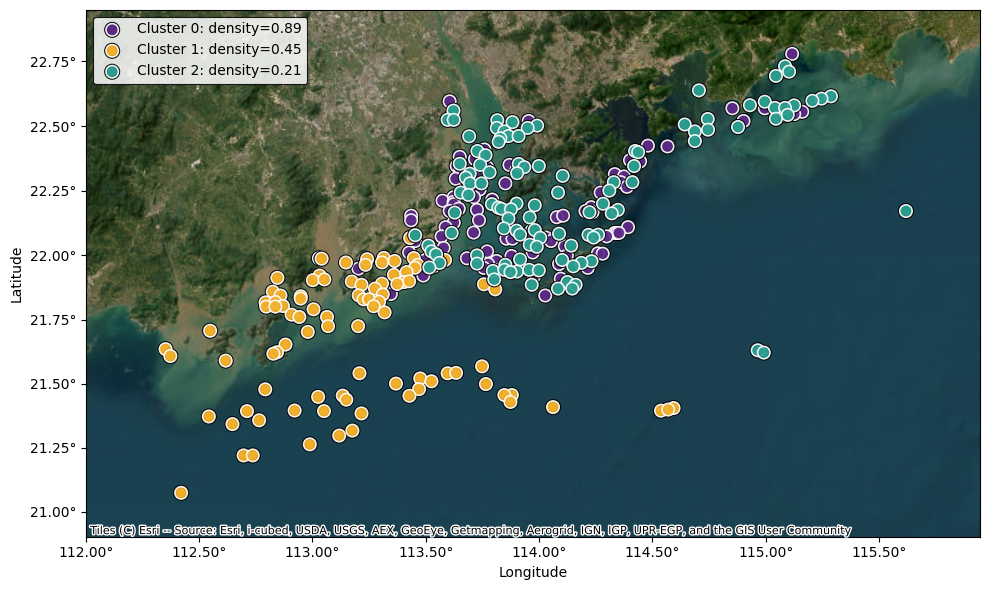

--- density ---
Cluster Centers (in original scale):
   centroid_lon  centroid_lat   density
0    113.954725     22.169243  0.892473
1    113.201601     21.681789  0.453776
2    114.142315     22.242840  0.213868




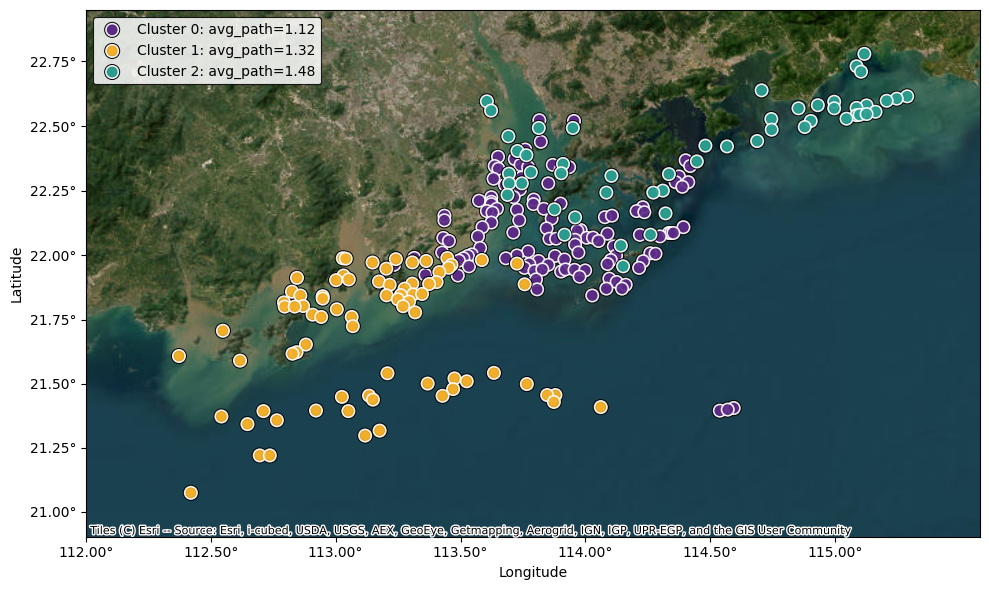

--- avg_path_length ---
Cluster Centers (in original scale):
   centroid_lon  centroid_lat  avg_path_length
0    113.891851     22.089712         1.121839
1    113.151956     21.698576         1.321119
2    114.442587     22.423709         1.480678




In [ ]:

!pip -q install geopandas shapely pyproj contextily

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import contextily as ctx
from pyproj import Transformer
import matplotlib.patheffects as pe

# ===== Utility Functions: Latitude and Longitude <-> Web Mercator Conversion and Latitude/Longitude Scale Settings =====
to_3857 = Transformer.from_crs(4326, 3857, always_xy=True)
to_4326 = Transformer.from_crs(3857, 4326, always_xy=True)

def lonlat_to_3857(lon, lat):
    x, y = to_3857.transform(lon, lat)
    return np.asarray(x), np.asarray(y)

def set_lonlat_ticks(ax, lon_min, lon_max, lat_min, lat_max):
    """Set latitude and longitude scales and labels on the axis with 3857 as the coordinate."""
    def choose_step(span):
        if span > 40: return 10
        if span > 20: return 5
        if span > 10: return 2
        if span > 5:  return 1
        if span > 2:  return 0.5
        if span > 1:  return 0.25
        return 0.1

    lon_step = choose_step(lon_max - lon_min)
    lat_step = choose_step(lat_max - lat_min)

    lon_ticks_deg = np.arange(np.floor(lon_min/lon_step)*lon_step, lon_max+1e-9, lon_step)
    lat_ticks_deg = np.arange(np.floor(lat_min/lat_step)*lat_step, lat_max+1e-9, lat_step)

    xticks_3857, _ = lonlat_to_3857(lon_ticks_deg, np.zeros_like(lon_ticks_deg))
    _, yticks_3857 = lonlat_to_3857(np.zeros_like(lat_ticks_deg), lat_ticks_deg)

    ax.set_xticks(xticks_3857)
    ax.set_yticks(yticks_3857)
    ax.set_xticklabels([f"{v:.2f}°" for v in lon_ticks_deg])
    ax.set_yticklabels([f"{v:.2f}°" for v in lat_ticks_deg])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

def add_esri_basemap(ax):
    # Lower the layer of the background image to avoid visually obscuring the points.
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="EPSG:3857", zorder=0)

# ========= Your plotting and clustering section =========
parameters = ['density', 'avg_path_length']

colors = [
    "#5B2A86",  # 深紫
    "#F2AF29",  # 金黄
    "#2A9D8F"   # 蓝绿
]


for param in parameters:
    # 1) Preparation features: latitude and longitude + current indicators
    X = basin_metrics_df[['centroid_lon', 'centroid_lat', param]].dropna().copy()

    lon_min, lon_max = X['centroid_lon'].min(), X['centroid_lon'].max()
    lat_min, lat_max = X['centroid_lat'].min(), X['centroid_lat'].max()

    # 2) Standardization + Clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[['centroid_lon', 'centroid_lat', param]])

    kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
    cluster_labels = kmeans.fit_predict(X_scaled)
    X['Cluster'] = cluster_labels

    # 3) Latitude and longitude to 3857 coordinates
    X['x3857'], X['y3857'] = lonlat_to_3857(X['centroid_lon'].values, X['centroid_lat'].values)

    # 4) Drawing
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the visible area (set the area first to make it easier to stretch the base image correctly).
    x_min, x_max = X['x3857'].min(), X['x3857'].max()
    y_min, y_max = X['y3857'].min(), X['y3857'].max()
    pad_x = (x_max - x_min) * 0.10 if x_max > x_min else 1000
    pad_y = (y_max - y_min) * 0.10 if y_max > y_min else 1000
    ax.set_xlim(x_min - pad_x, x_max + pad_x)
    ax.set_ylim(y_min - pad_y, y_max + pad_y)


    add_esri_basemap(ax)

    for cl in sorted(X['Cluster'].unique()):
        subset = X[X['Cluster'] == cl]
        mean_val = subset[param].mean()

        if param == 'avg_path_length':
            label_str = f'Cluster {cl}: avg_path={mean_val:.2f}'
        elif param == 'density':
            label_str = f'Cluster {cl}: density={mean_val:.2f}'
        else:
            label_str = f'Cluster {cl}: {param}={mean_val:.2f}'

        sc = ax.scatter(
            subset['x3857'],
            subset['y3857'],
            s=80,
            c=colors[cl],
            marker='o',
            alpha=0.92,
            edgecolors='white',
            linewidths=1.2,
            label=label_str,
            zorder=10
        )


        sc.set_path_effects([
            pe.Stroke(linewidth=2.6, foreground='black'),
            pe.Normal()
        ])


    set_lonlat_ticks(ax, lon_min, lon_max, lat_min, lat_max)


    leg = ax.legend(loc="best", frameon=True, fontsize=10)
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_alpha(0.85)
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(0.8)

    ax.grid(False)
    plt.tight_layout()


    save_path = f"/content/drive/My Drive/Oyster_Flow/kmeans_cluster_{param}_esri1219.pdf"
    plt.savefig(save_path, format='pdf', dpi=300)
    plt.show()

    # Cluster center anti-standardization
    centers_scaled = kmeans.cluster_centers_
    centers_orig = scaler.inverse_transform(centers_scaled)
    print(f"--- {param} ---")
    print("Cluster Centers (in original scale):")
    print(pd.DataFrame(
        centers_orig,
        columns=['centroid_lon', 'centroid_lat', param]
    ))
    print("\n")


Decompressing WhiteboxTools_linux_musl.zip ...
WhiteboxTools package directory: /usr/local/lib/python3.11/dist-packages/whitebox


阈值遍历:   0%|          | 0/35 [00:00<?, ?it/s]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='0' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:   3%|▎         | 1/35 [00:27<15:31, 27.40s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='1' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:   6%|▌         | 2/35 [00:38<09:40, 17.61s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='2' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:   9%|▊         | 3/35 [00:44<06:36, 12.38s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='3' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:  11%|█▏        | 4/35 [00:49<04:50,  9.37s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='4' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:  14%|█▍        | 5/35 [00:51<03:30,  7.03s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='5' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:  17%|█▋        | 6/35 [00:54<02:36,  5.41s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='6' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:  20%|██        | 7/35 [00:56<02:00,  4.29s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='7' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:  23%|██▎       | 8/35 [00:57<01:32,  3.44s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='8' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:  26%|██▌       | 9/35 [00:59<01:13,  2.82s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='9' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Prog

阈值遍历:  29%|██▊       | 10/35 [01:01<01:02,  2.52s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='10' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  31%|███▏      | 11/35 [01:02<00:54,  2.28s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='11' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  34%|███▍      | 12/35 [01:04<00:47,  2.06s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='12' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  37%|███▋      | 13/35 [01:05<00:40,  1.86s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='13' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  40%|████      | 14/35 [01:07<00:36,  1.72s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='14' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  43%|████▎     | 15/35 [01:08<00:32,  1.61s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='15' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  46%|████▌     | 16/35 [01:09<00:28,  1.52s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='16' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  49%|████▊     | 17/35 [01:11<00:26,  1.47s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='17' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  51%|█████▏    | 18/35 [01:12<00:23,  1.40s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='18' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  54%|█████▍    | 19/35 [01:13<00:22,  1.38s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='19' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  57%|█████▋    | 20/35 [01:15<00:21,  1.41s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='20' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  60%|██████    | 21/35 [01:16<00:19,  1.37s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='21' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  63%|██████▎   | 22/35 [01:17<00:17,  1.37s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='22' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  66%|██████▌   | 23/35 [01:19<00:15,  1.33s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='23' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  69%|██████▊   | 24/35 [01:20<00:14,  1.28s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='24' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  71%|███████▏  | 25/35 [01:21<00:12,  1.25s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='25' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  74%|███████▍  | 26/35 [01:22<00:11,  1.23s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='26' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  77%|███████▋  | 27/35 [01:23<00:09,  1.22s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='27' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  80%|████████  | 28/35 [01:25<00:08,  1.19s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='28' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

阈值遍历:  83%|████████▎ | 29/35 [01:26<00:07,  1.20s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='29' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  86%|████████▌ | 30/35 [01:27<00:05,  1.20s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='30' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  89%|████████▊ | 31/35 [01:28<00:05,  1.27s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='31' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  91%|█████████▏| 32/35 [01:30<00:03,  1.29s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='32' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  94%|█████████▍| 33/35 [01:31<00:02,  1.32s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='33' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历:  97%|█████████▋| 34/35 [01:32<00:01,  1.28s/it]

./whitebox_tools --run="ExtractStreams" --wd="/content/drive/My Drive/Oyster_Flow" --flow_accum='/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif' --output='/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif' --threshold='34' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Pro

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
阈值遍历: 100%|██████████| 35/35 [01:33<00:00,  2.68s/it]


    threshold  n_samples        R2
0           0       2848  0.533766
1           1       1881  0.421957
2           2       1382  0.478850
3           3        985  0.431886
4           4        730  0.654615
5           5        557  0.667025
6           6        426  0.590336
7           7        328  0.366981
8           8        248  0.639365
9           9        189  0.527011
10         10        155  0.630562
11         11        132  0.689964
12         12        112  0.682650
13         13         93  0.691345
14         14         81  0.606320
15         15         65  0.648884
16         16         51  0.771573
17         17         44  0.755312
18         18         36  0.870648
19         19         32  0.879359
20         20         22  0.848828
21         21         19  0.800000
22         22         15  0.803279
23         23         14  0.799014
24         24         12  0.800000
25         25         12  0.800000
26         26          9  0.800000
27         27       

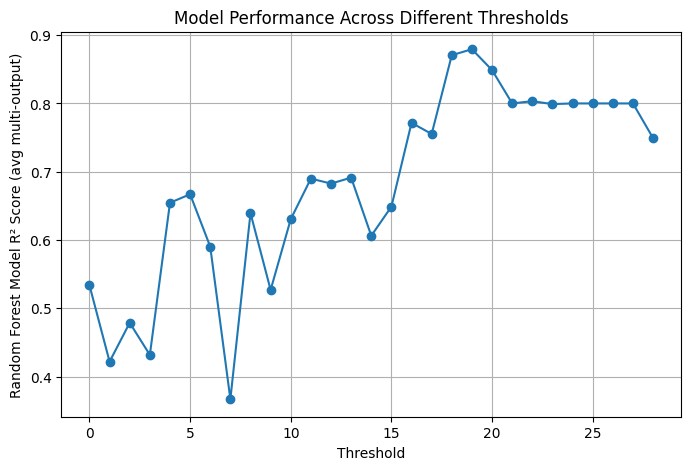

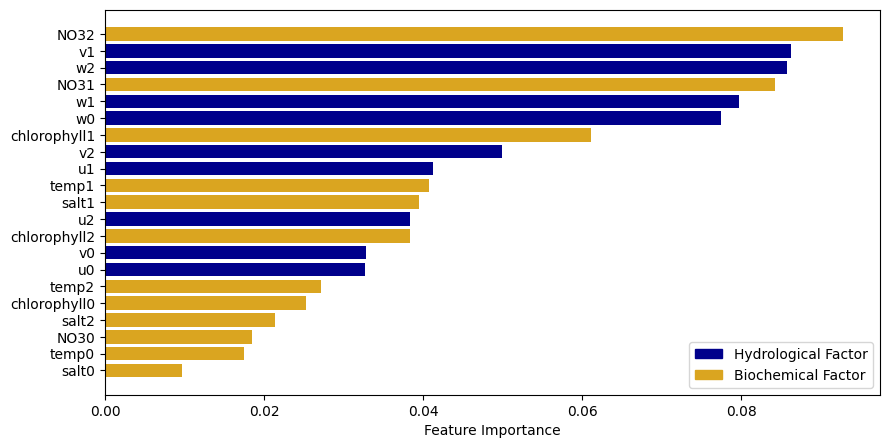

In [ ]:

import os
import numpy as np
import pandas as pd
import rasterio
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import whitebox
import matplotlib.patches as mpatches


logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")


wbt = whitebox.WhiteboxTools()
wbt.set_working_dir("/content/drive/My Drive/Oyster_Flow")


flow_accum = "/content/drive/My Drive/Oyster_Flow/FlowAcc_Flow51.tif"
flow_dir   = "/content/drive/My Drive/Oyster_Flow/FlowDir_Fill31.tif"
streams_rast   = "/content/drive/My Drive/Oyster_Flow/HS_slope_streams.tif"
stream_link_r  = "/content/drive/My Drive/Oyster_Flow/HS_slope_link.tif"
stream_order_r = "/content/drive/My Drive/Oyster_Flow/HS_slope_order.tif"


threshold_list = list(range(52))


base_dir = "/content/drive/My Drive/Oyster_Flow/OFG_New/"
biogeo_tifs = [
    "NO30.tif", "NO31.tif", "NO32.tif",
    "chlorophyll0.tif", "chlorophyll1.tif", "chlorophyll2.tif",
    "salt0.tif", "salt1.tif", "salt2.tif",
    "temp0.tif", "temp1.tif", "temp2.tif",
    "u0.tif", "u1.tif", "u2.tif",
    "v0.tif", "v1.tif", "v2.tif",
    "w0.tif", "w1.tif", "w2.tif"
]



def preload_tifs(tif_list, base_directory):
    tif_arrays = {}
    logging.info("预加载环境变量 TIF 数据...")
    for f in tqdm(tif_list, desc="加载 TIF 文件"):
        tif_path = os.path.join(base_directory, f)
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1).astype(np.float32)
                if src.nodata is not None:
                    data = np.where(data == src.nodata, np.nan, data)
            tif_arrays[f] = data
        except Exception as e:
            logging.error(f"读取 {tif_path} 时出错: {e}")
    return tif_arrays

tif_arrays = preload_tifs(biogeo_tifs, base_dir)


def extract_network(threshold):
    try:

        wbt.extract_streams(flow_accum, streams_rast, threshold)
        wbt.stream_link_class(d8_pntr=flow_dir, streams=streams_rast, output=stream_link_r)
        wbt.strahler_stream_order(d8_pntr=flow_dir, streams=streams_rast, output=stream_order_r)
    except Exception as e:
        logging.error(f"WhiteboxTools 处理阈值 {threshold} 时出错: {e}")
        return None, None, None, None, None, None

    try:
        with rasterio.open(streams_rast) as src:
            streams_data = src.read(1).astype(np.float32)
            transform = src.transform
            streams_crs = src.crs
        with rasterio.open(flow_accum) as src:
            flow_acc_data = src.read(1).astype(np.float32)
        flow_acc_data[flow_acc_data < 0] = 0
        with rasterio.open(stream_order_r) as src:
            stream_order_data = src.read(1).astype(np.float32)
    except Exception as e:
        logging.error(f"读取栅格数据时出错: {e}")
        return None, None, None, None, None, None

    # Constructing the network graph: Select only nodes with flow network cells (value > 0).
    graph = nx.Graph()
    rows, cols = np.where(streams_data > 0)
    for r, c in zip(rows, cols):
        graph.add_node((r, c),
                       flow_acc=flow_acc_data[r, c],
                       stream_order=stream_order_data[r, c])

    for r, c in zip(rows, cols):
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < streams_data.shape[0] and 0 <= nc < streams_data.shape[1]:
                if streams_data[nr, nc] > 0:
                    graph.add_edge((r, c), (nr, nc))
    return graph, streams_data, transform, flow_acc_data, stream_order_data, streams_crs


def process_threshold(th, tif_arrays, biogeo_tifs):
    logging.info(f"Processing threshold = {th}")
    graph, streams_data, transform, flow_acc_data, stream_order_data, streams_crs = extract_network(th)
    if graph is None:
        return None


    num_components = nx.number_connected_components(graph)
    flow_efficiency = (np.mean([d["flow_acc"] for _, d in graph.nodes(data=True)])
                       if graph.number_of_nodes() > 0 else 0)

    if graph.number_of_nodes() > 0:
        deg_cent = nx.degree_centrality(graph)
        bet_cent = nx.betweenness_centrality(graph)
    else:
        deg_cent = {}
        bet_cent = {}

    samples = []
    for node in graph.nodes():
        r, c = node
        node_data = graph.nodes[node]
        y_dict = {
            "Connectivity": num_components,
            "Flow_Efficiency": flow_efficiency,
            "Degree_Centrality": deg_cent.get(node, 0),
            "Betweenness_Centrality": bet_cent.get(node, 0),
            "Stream_Order": node_data["stream_order"]
        }
        x_vals = []
        for f in biogeo_tifs:
            arr = tif_arrays.get(f, None)
            if arr is None:
                val = np.nan
            else:
                try:
                    val = arr[r, c]
                except IndexError:
                    val = np.nan
            x_vals.append(val)

        row = {os.path.splitext(f)[0]: val for f, val in zip(biogeo_tifs, x_vals)}
        row.update(y_dict)
        row["threshold"] = th
        samples.append(row)

    df_th = pd.DataFrame(samples)
    df_th.dropna(inplace=True)
    if df_th.empty:
        logging.warning(f"Threshold {th} 得到的样本为空。")
        return None

    # Define target variable and feature variables
    target_cols = ["Connectivity", "Flow_Efficiency", "Degree_Centrality", "Betweenness_Centrality", "Stream_Order"]
    feature_cols = [c for c in df_th.columns if c not in (target_cols + ["threshold"])]
    df_x = df_th[feature_cols]
    df_y = df_th[target_cols]

    # Split the dataset and train a random forest model
    X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
    #rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=5, random_state=42, n_jobs=-1)

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    feature_importance = rf.feature_importances_
    fi_df = pd.DataFrame({"Feature": feature_cols, "Importance": feature_importance}).sort_values("Importance", ascending=False)

    result = {"threshold": th, "n_samples": df_th.shape[0], "R2": r2, "fi_df": fi_df, "df": df_th}
    logging.info(f"Threshold {th}: Samples={df_th.shape[0]}, R2={r2:.4f}")
    return result

# Main process: Iterate through multiple thresholds and collect results.
def main():
    model_results = []

    for th in tqdm(range(35), desc="阈值遍历"):
        res = process_threshold(th, tif_arrays, biogeo_tifs)
        if res is not None:
            model_results.append(res)

    if not model_results:
        logging.error("没有有效的模型结果，程序终止。")
        return


    results_summary = pd.DataFrame([
        {"threshold": res["threshold"], "n_samples": res["n_samples"], "R2": res["R2"]}
        for res in model_results
    ])
    logging.info("Summary of model results for each threshold:")
    print(results_summary)

    # Plot the relationship between the threshold and R².
    plt.figure(figsize=(8, 5))
    plt.plot(results_summary["threshold"], results_summary["R2"], marker="o", linestyle='-')
    plt.xlabel("Threshold")
    plt.ylabel("Random Forest Model R² Score (avg multi-output)")
    plt.title("Model Performance Across Different Thresholds")
    plt.grid(True)
    plt.show()


    result_th0 = next((res for res in model_results if res["threshold"] == 0), None)
    if result_th0 is None:
        logging.error("未找到阈值为 0 的模型结果，无法绘制特征重要性图。")
    else:
        fi_df_th0 = result_th0["fi_df"]
        features = fi_df_th0["Feature"]
        importances = fi_df_th0["Importance"]

        # Define 9 hydrological variables
        hydro_vars = ["u0", "u1", "u2", "v0", "v1", "v2", "w0", "w1", "w2"]

        # The color of each bar is determined by its variable name: dark blue for hydrological variables and golden yellow for other variables.
        colors = ["darkblue" if f in hydro_vars else "goldenrod" for f in features]

        plt.figure(figsize=(10, 5))
        plt.barh(features, importances, color=colors)
        plt.gca().invert_yaxis()
        plt.xlabel("Feature Importance")


        hydro_patch = mpatches.Patch(color='darkblue', label='Hydrological Factor')
        bio_patch = mpatches.Patch(color='goldenrod', label='Biochemical Factor')
        plt.legend(handles=[hydro_patch, bio_patch], loc='lower right')


        plt.savefig("feature_importance.pdf", format="pdf")


        plt.show()

    # Optional: Save the results to a CSV file
    results_summary.to_csv("model_results_summary.csv", index=False)

    if result_th0 is not None:
        result_th0["df"].to_csv(f"model_data_threshold_{result_th0['threshold']}.csv", index=False)
    logging.info("结果已保存到本地。")

if __name__ == "__main__":
    main()
